# Libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix,plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# Rename column names to human-readable format
### Raw data has 40k rows. Data is downsampled to 10k rows.

In [2]:
sns.set(style="darkgrid", font_scale=1.2)
bank_data = pd.read_csv('bank-additional-full.csv', delimiter= ';')[-10000:]
bank_data = bank_data.rename(columns={'default': 'hasCredit'})
bank_data = bank_data.rename(columns={'housing': 'hasHousingLoan'})
bank_data = bank_data.rename(columns={'poutcome': 'prevCampaignOutcome'})
bank_data = bank_data.rename(columns={'loan': 'hasLoan'})
bank_data = bank_data.rename(columns={'emp.var.rate': 'employmentVariationRate'})

# Helper Functions

In [3]:
#plots categorical attributes
def plot_c(label):
    plt.rcParams["figure.figsize"] = (20,10)
    Y = bank_data[label]
    total = len(Y)*1.
    ax=sns.countplot(x=label, data=bank_data, hue="y")
    for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
    ax.yaxis.set_ticks(np.linspace(0, total, 11))
    ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.title(f"Class distribution of {label}")
    plt.show()

#plots numerical features
def plot_n(label):
    plt.rcParams["figure.figsize"] = (8,5)
    sns.boxplot(data = bank_data, x="y", y=label)
    plt.title(f"Class distribution of {label}")
    plt.show()

#correlation matrix
def corr_matrix():
    corr = bank_data.corr()
    f, ax = plt.subplots(figsize=(10,1))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    _ = sns.heatmap(corr, cmap="Blues", square=True, ax=ax, annot=True, linewidth=0.1)
    plt.title("Correlation of Features", y=1.05, size=15)
    plt.show()

In [20]:
#plots roc curve
def plot_roc(y_test, y_pred):
    no_skill = [0 for _ in range(len(y_test))]
    y_pred = y_pred[:, 1]
    ns_auc = roc_auc_score(y_test, no_skill)
    lr_auc = roc_auc_score(y_test, y_pred)
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    ns_fpr, ns_tpr, _ = roc_curve(y_test, no_skill)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression')
    plt.title('with duration column')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# Exploratory Data Analysis

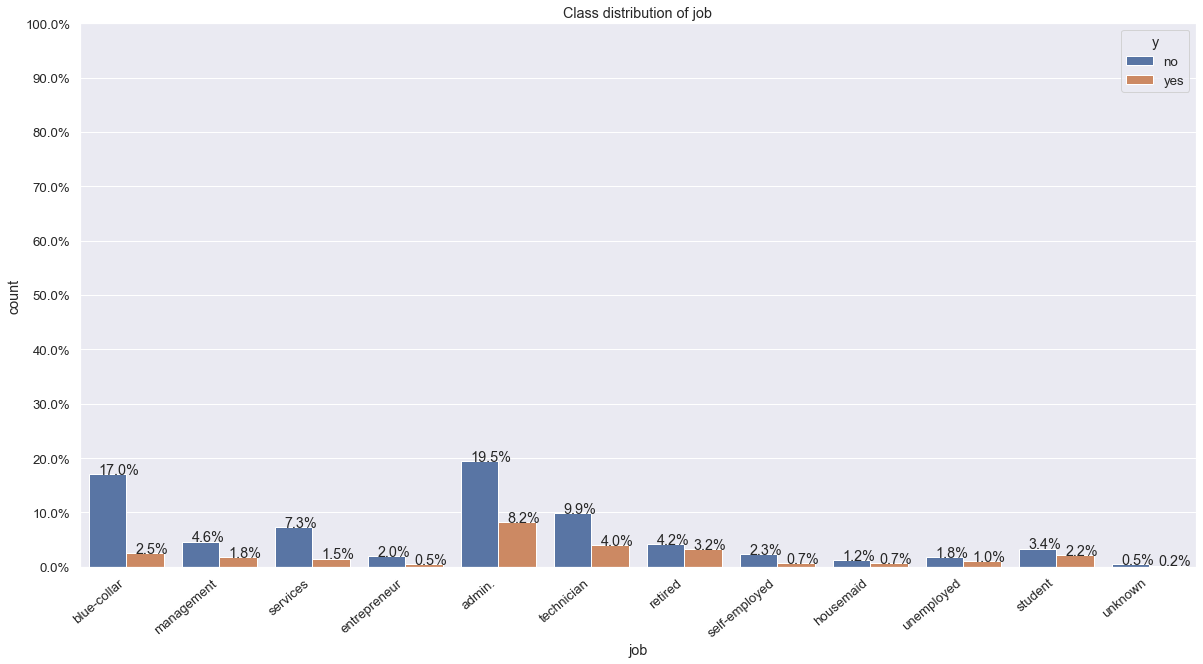

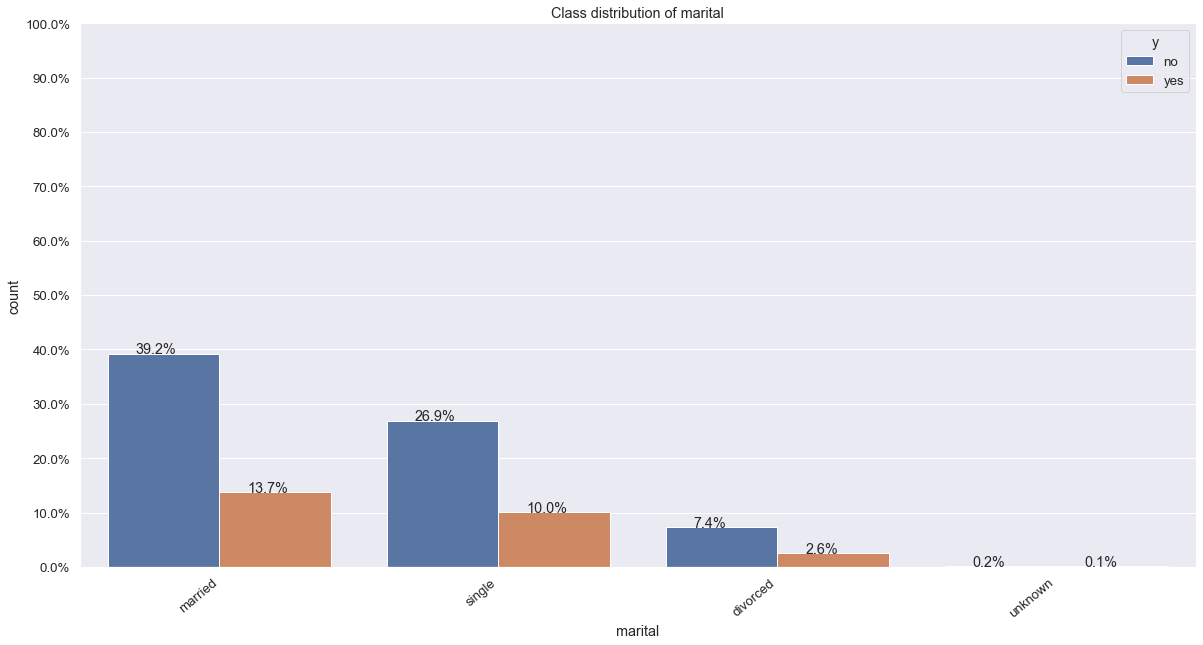

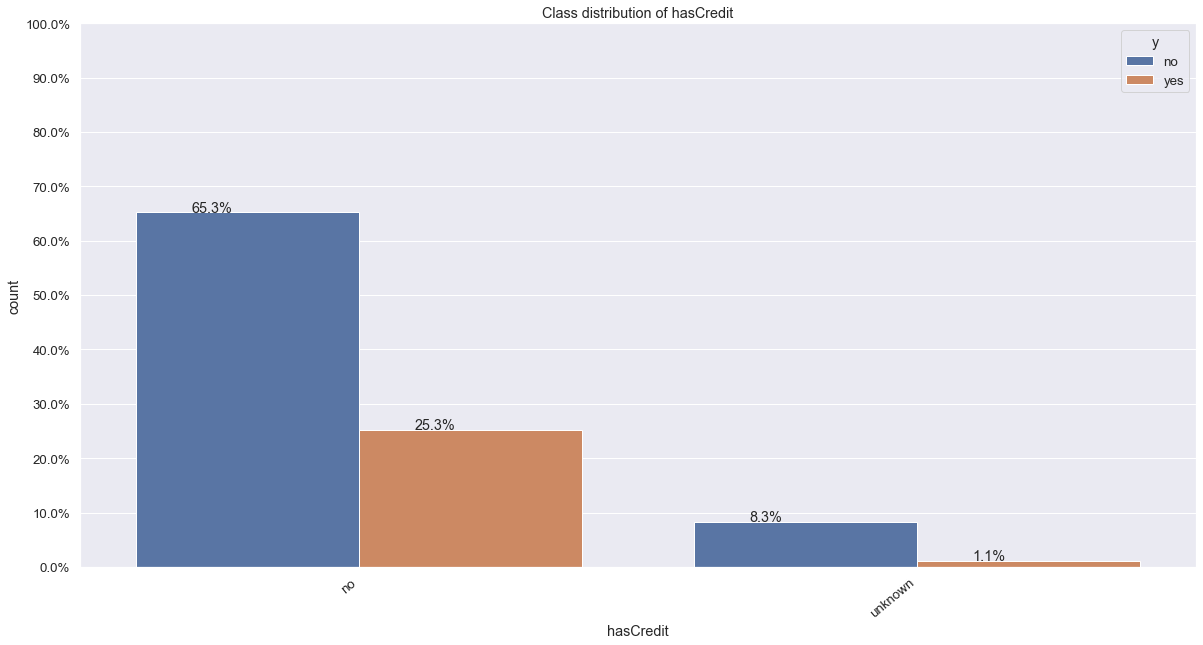

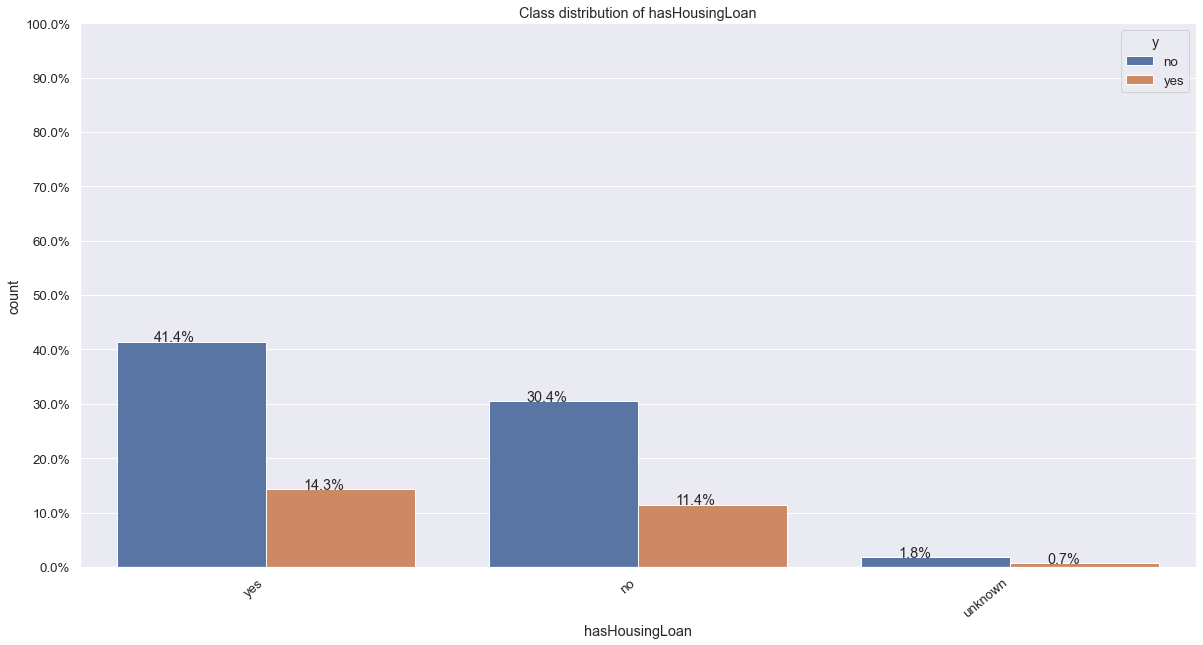

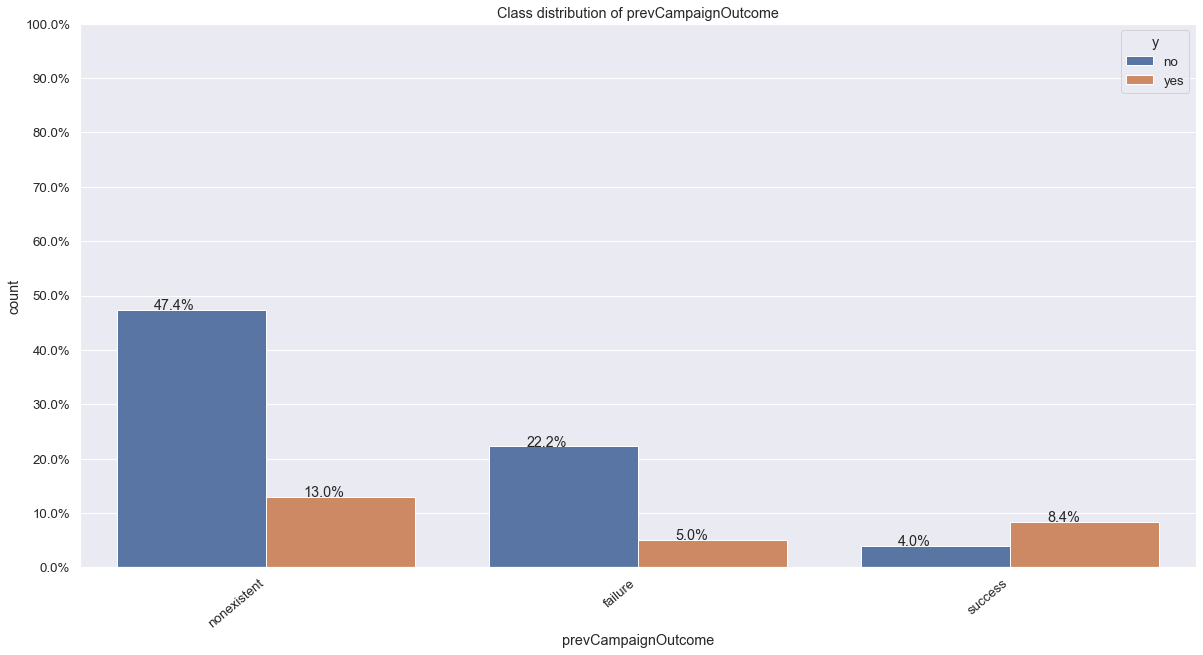

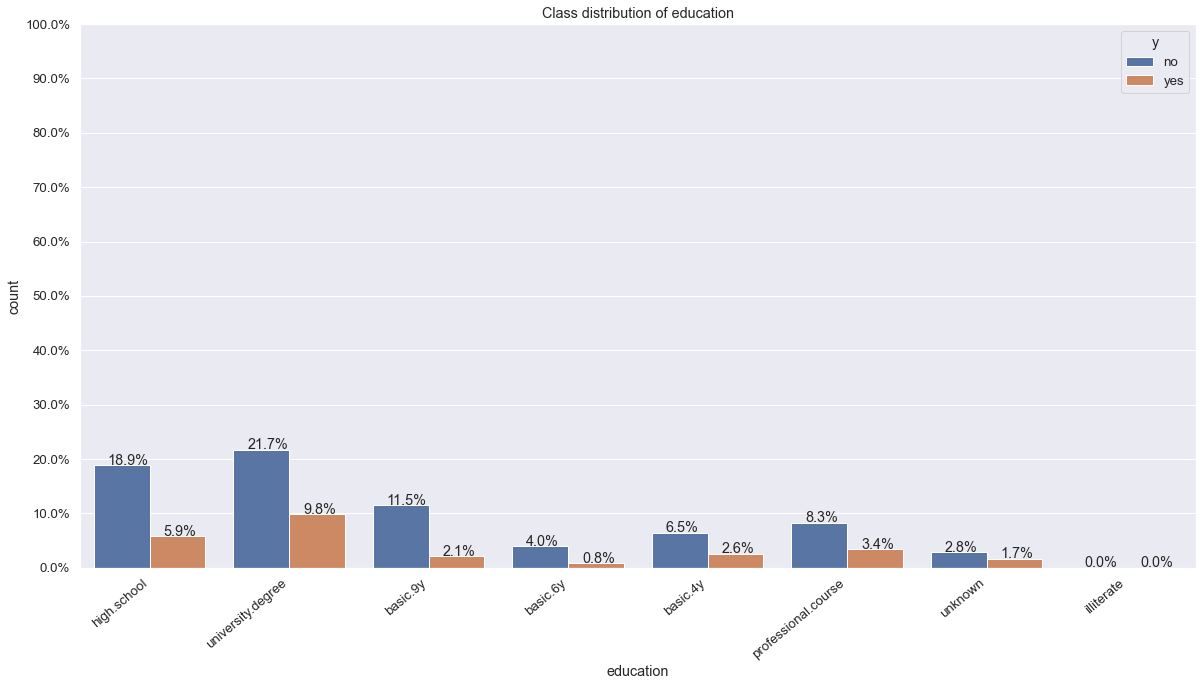

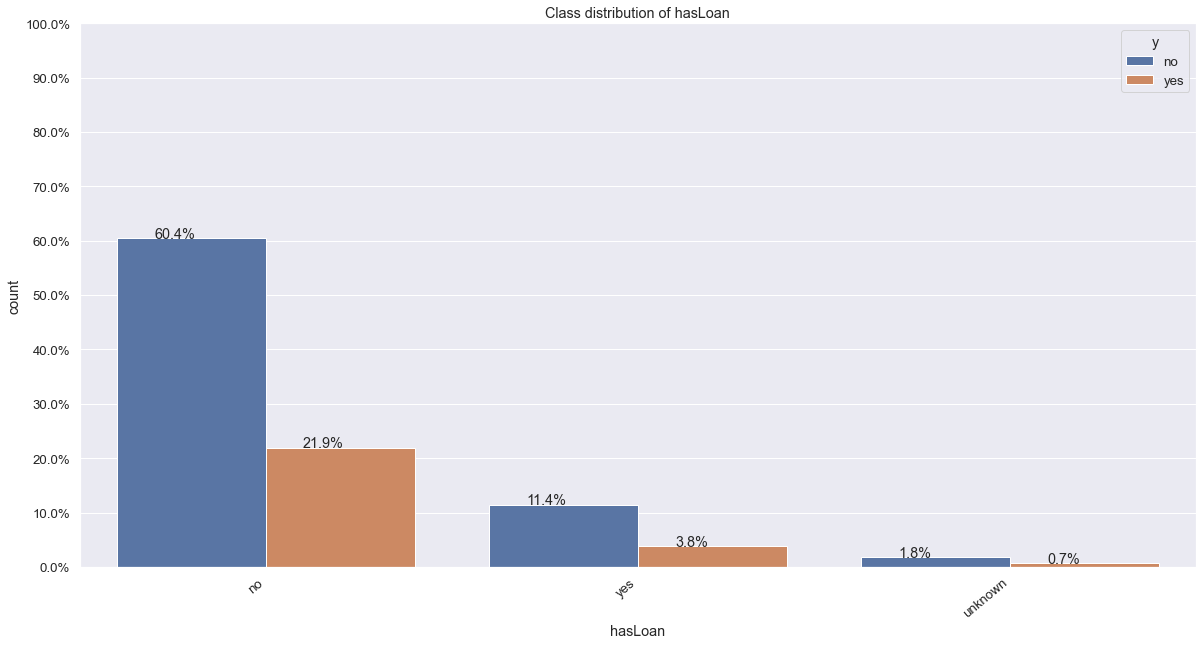

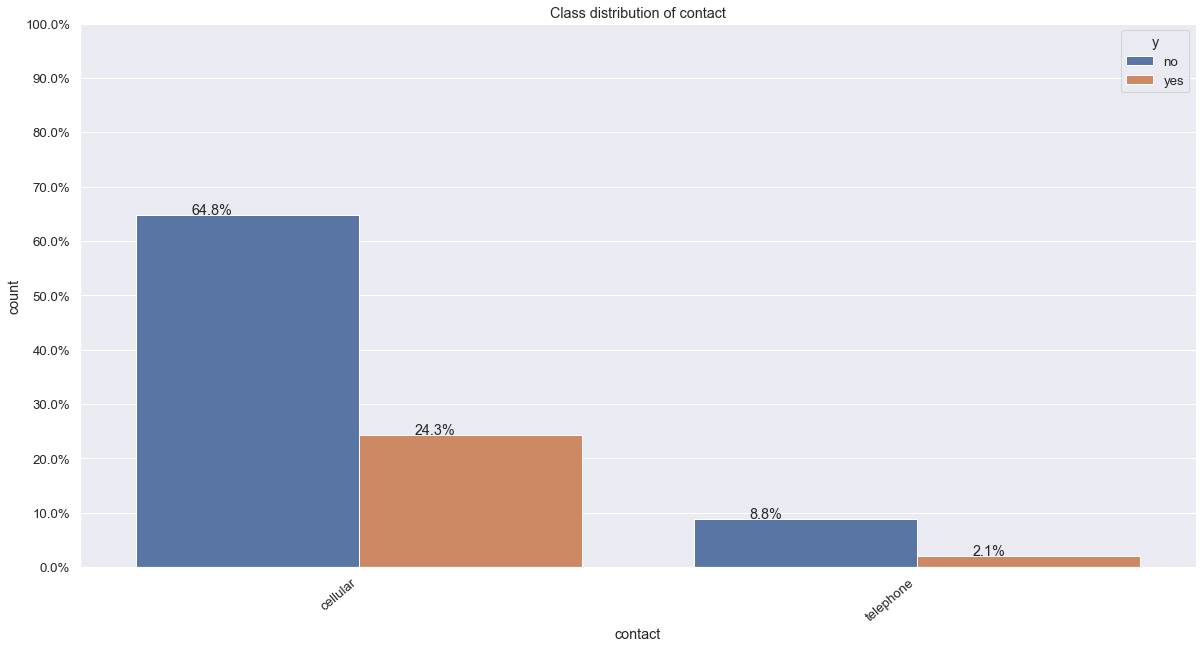

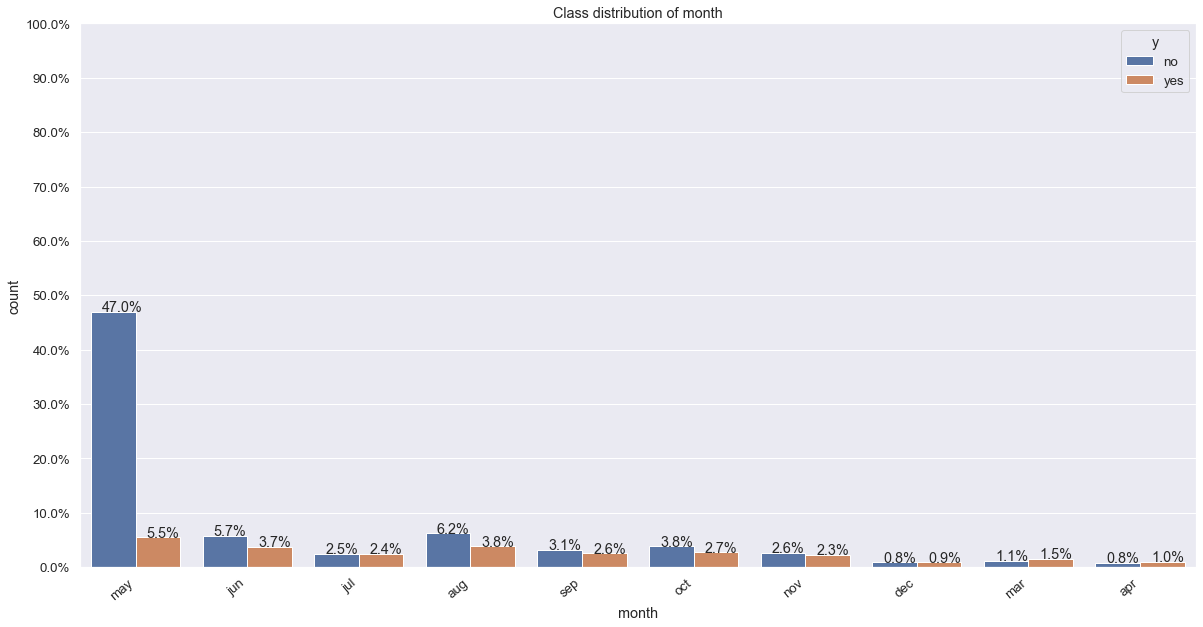

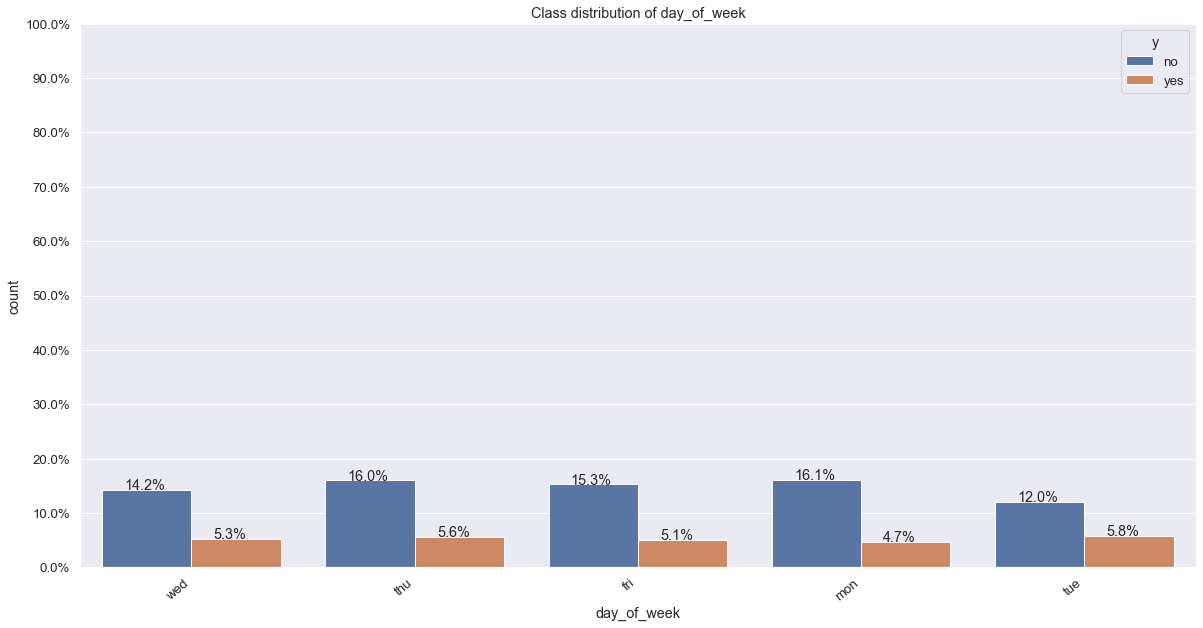

In [4]:
plot_c("job")
plot_c("marital")
plot_c("hasCredit")
plot_c("hasHousingLoan")
plot_c("prevCampaignOutcome")
plot_c("education")
plot_c("hasLoan")
plot_c("contact")
plot_c("month")
plot_c("day_of_week")

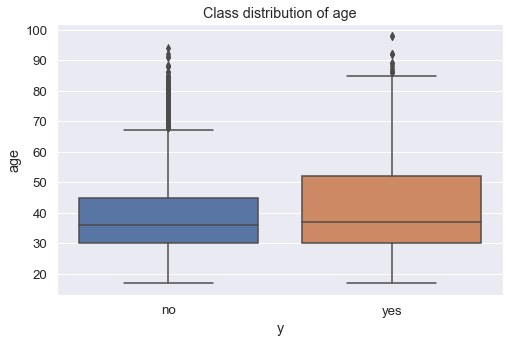

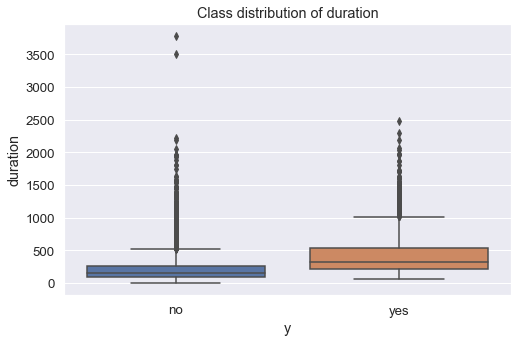

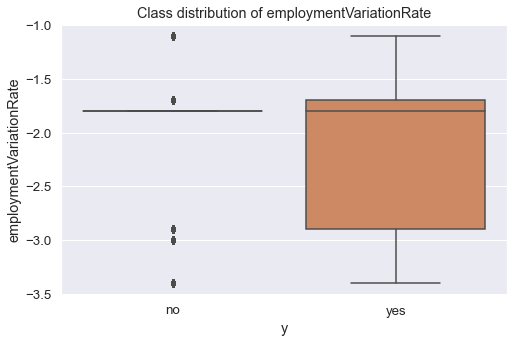

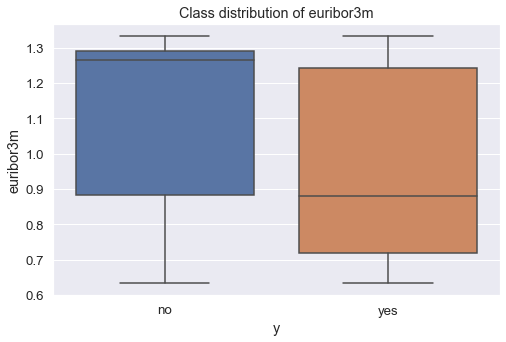

In [5]:
plot_n("age")
plot_n("duration")
plot_n("employmentVariationRate")
plot_n("euribor3m")

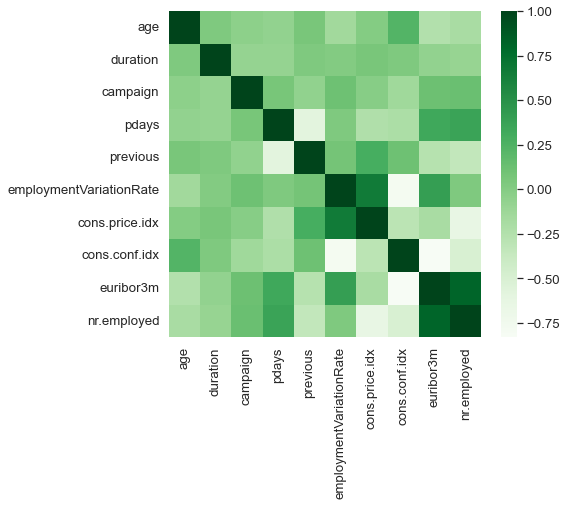

In [6]:
corr = bank_data.corr()

plt.figure(figsize=(7,6))
_ = sns.heatmap(corr.round(2), cmap="Greens")

# Observations
### Day of the telemarketing call has no effect on the customerâ€™s decision. Day feature could be deduced.
### Age feature could be deduced. "no" and "yes" have the same average of age.
### duration should be deduced for realistic predictions. However, it is a significant indicator. It can be used for benchmark purposes.

# Data Preprocessing
### Duplicates are removed. age and day_of_week features are removed.

In [7]:
bank_data = bank_data.drop_duplicates()
bank_data = bank_data.drop('age',1)
bank_data = bank_data.drop('day_of_week',1)
bank_data = bank_data.reset_index()

In [8]:
bank_data_x = bank_data.iloc[:, :-1]
bank_data_y = bank_data["y"]

### Split dataset for train,validation and test

In [9]:
X_, X_test, y_, y_test                         = train_test_split(bank_data_x, bank_data_y, test_size=0.2)
X_train, X_validation, y_train, y_validation   = train_test_split(X_, y_, test_size=0.2)

In [10]:
y_train.replace({"no":0, "yes":1}, inplace=True)
y_validation.replace({"no":0, "yes":1}, inplace=True)
y_test.replace({"no":0, "yes":1}, inplace=True)

# One-hot Encoding
### It is used for encoding the categorical features of the data. 

In [11]:
categorical_features = bank_data_x.columns[bank_data_x.dtypes==object].tolist()

In [12]:
def add_onehot_to_dataframe(sparse, df, vectorizer, name):
    for i, col in enumerate(vectorizer.get_feature_names()):
        column = name+"_"+col
        df[column] = sparse[:, i].toarray().ravel().tolist()
    return df

In [13]:
def OneHotEncoder(categorical_features, X_train, X_test, X_validation):
    for i in categorical_features:
        Vectorizer = CountVectorizer(token_pattern="[A-Za-z0-9-.]+")
        # Encoding training,validation and test datasets 
        X_train = add_onehot_to_dataframe(Vectorizer.fit_transform(X_train[i]), X_train, Vectorizer, i)
        X_validation = add_onehot_to_dataframe(Vectorizer.fit_transform(X_validation[i]), X_validation, Vectorizer, i)
        X_test = add_onehot_to_dataframe(Vectorizer.fit_transform(X_test[i]), X_test, Vectorizer, i)

In [14]:
OneHotEncoder(categorical_features, X_train, X_test, X_validation)

C:\Users\yaren sever\scoop\apps\python38\3.8.9\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [15]:
# Drop the categorical features as the one hot encoded representation is present
X_train = X_train.drop(categorical_features, axis=1)
X_validation = X_validation.drop(categorical_features, axis=1)
X_test = X_test.drop(categorical_features, axis=1)

print("Shape of train: ", X_train.shape)
print("Shape of CV: ", X_validation.shape)
print("Shape of test: ", X_test.shape)

Shape of train:  (6397, 57)
Shape of CV:  (1600, 57)
Shape of test:  (2000, 57)


In [16]:
X_train.drop('education_illiterate', axis=1, inplace=True)
X_test.drop('education_illiterate', axis=1, inplace=True)
X_train = X_train.drop(columns= ['index'], axis=1)
X_test = X_test.drop(columns= ['index'], axis=1)

# Logistic Regression

### Hyperparameter Tuning

In [ ]:
model = LogisticRegression()
max_iter = [20, 50, 100, 200, 500, 1000]
solvers = ['lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = dict(solver=solvers,penalty=penalty,C=c_values, max_iter = max_iter)
grid_search=GridSearchCV(model,grid,n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train,y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means  = grid_result.cv_results_['mean_test_score']
stds   = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
model = LogisticRegression(class_weight = 'balanced', penalty = 'l2', C = 0.1 , solver = 'lbfgs', max_iter=100)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)

In [ ]:
plot_roc(y_test, y_pred)

# SVM | Support Vector Classifier

In [26]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("AUC score with duration column: ", roc_auc_score(y_test, y_pred))
print("Accuracy score with duration column: ", accuracy_score(y_test, y_pred))
print("F1 score with duration column: ", f1_score(y_test, y_pred))

AUC score with duration column:  0.7351900885881467
Accuracy score with duration column:  0.813
F1 score with duration column:  0.6128364389233955


In [27]:
confusion_matrix(y_test, y_pred.round(0), labels=[0, 1])

array([[1330,  155],
       [ 219,  296]], dtype=int64)

In [ ]:
# emre notes:
# https://medium.com/nerd-for-tech/analysis-of-bank-marketing-dataset-by-using-support-vector-machine-svm-1ccae6eaa782
# here duplicates are not dropped because there is no unique ID
# also since duration highly affects y, it's dropped
# finally, to reduce imbalance, SMOTE is used

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100, random_state = 20)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("AUC score with duration column: ", roc_auc_score(y_test, y_pred))
print("Accuracy score with duration column: ", accuracy_score(y_test, y_pred.round(0)))
print("F1 score with duration column: ", f1_score(y_test, y_pred.round(0)))

In [ ]:
confusion_matrix(y_test, y_pred.round(0), labels=[0, 1])

In [ ]:
X_train_no_duration = X_train[[c for c in X_train.columns if c != 'duration']]
X_test_no_duration = X_test[[c for c in X_test.columns if c != 'duration']]

rf.fit(X_train_no_duration, y_train)
y_pred = rf.predict(X_test_no_duration)

print("AUC score with duration column: ", roc_auc_score(y_test, y_pred))
print("Accuracy score with duration column: ", accuracy_score(y_test, y_pred.round(0)))
print("F1 score with duration column: ", f1_score(y_test, y_pred.round(0)))

In [ ]:
y_pred_binary = [round(p) for p in y_pred]
confusion_matrix(y_test, y_pred_binary, labels=[0, 1])